# AUTOENCODER

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models, optimizers, callbacks
import tensorflow.keras.backend as K # para poder definir funciones propias de keras
import matplotlib.pyplot as plt

2025-02-10 15:59:57.884376: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-10 15:59:57.888878: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-10 15:59:57.901788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739203197.923315    4324 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739203197.931095    4324 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 15:59:57.955636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Definimos los parámetros de la red
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

In [3]:
from tensorflow.keras import datasets
((x_train, y_train), (x_test, y_test)) = datasets.fashion_mnist.load_data()
print(x_train.shape, y_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28) (60000,)


In [4]:
def preprocess(imgs): # Preprocesado de las imágenes
    imgs = imgs.astype('float32')/255.0 # Normalización de las imágenes. Pasar a valores entre 0 y 1, en vez de entre 0 y 255
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0) # Añadir padding de 2 píxeles a cada lado.
    imgs = np.expand_dims(imgs, -1) # Añadir una dimensión al final para el canal de color
    return imgs # Retornar las imágenes con la forma adecuada

In [5]:
# Preprocesar las imágenes de los conjuntos de entrenamiento y test.
x_train = preprocess(x_train)
x_test = preprocess(x_test)


## Arquitectura del autocodificador   

Un autoencoder/autocodificador es una red neuronal formada por dos partes:   
- Una red **codificadora**, que comprime datos de entrada de muchas dimensiones, como por ejemplo, una imagen, generando un vector denominado **"espacio latente"** o **"cuello de botella"** (bottle neck) de pocas dimensiones.   
- Una red **decodificadora**, que descomprime el vector del "espacio latente" dado y lo devuelve a su dominio original (por ejemplo, transformándolo de nuevo en una imagen), intentando reconstruirla de la forma más fidedigna posible. Esta red neuronal suele disponer de una estructura simétrica a la de la red codificadora.   


<img src="./img/autoencoder.png" width="700">

El autoencoder se entrena para reconstruir, en nuestro caso, una imagen, pasando primero por el codificador y saliendo por el decodificador.    

### Función de Pérdida (Loss Function)   

La función de pérdida mide la diferencia entre la entrada original y la salida reconstruida. El objetivo del autoencoder es minimizar esta diferencia, optimizando así su capacidad para aprender representaciones útiles de los datos. Una función de pérdida común es el error cuadrático medio (MSE), que cuantifica qué tan bien se está reconstruyendo la información.

### Arquitectura de la red codificadora   

La tarea del codificador es tomar la imagen de entrada y asignarla a un vector del espacio latente. La arquitectura del codificador que vamos a construir consta de las siguiente capas:   
- Capa de entrada (32,32,1)
- Convolucional 2D (16,16, 32)
- Convolucional 2D (8,8, 64)
- Convolucional 2D (4,4, 128)
- Aplanado (2048)
- Densa (2)

In [6]:
encoder_input = layers.Input(shape=(32, 32, 1), name = "encoder_input") # Definir la entrada del codificador
x=layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input) # Capa convolucional
x=layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x) # Capa convolucional
x=layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x) # Capa convolucional
shape_before_flattening = K.int_shape(x)[1:] # Obtener la forma de la salida de la última capa convolucional
x=layers.Flatten()(x) # Aplanar la salida de la última capa convolucional
encoder_output = layers.Dense(2, name="encoder_output")(x) # Capa densa de salida del codificador

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

2025-02-10 16:00:27.255961: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

### Arquitectura de la red decodificadora    

Como ya hemos dicho, el decodificador tiene un diseño simétrico del codificador. En este caso, en lugar de las capas de convolución 2D "normales", utilizaremos las capas convolucionales 2D traspuestas. La estructura de la red decodificadora nos queda:   

- Capa de entrada (2)
- Densa (2048)
- Reformatear (4,4, 128) (Reshape)
- Convolucional 2D Traspuesta (8,8, 128)
- Convolucional 2D Traspuesta (16,16, 64)
- Convolucional 2D Traspuesta (32,32, 32)
- Convolucional 2D (32,32, 1)

In [7]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

### Diseño del Autoencoder   

Para entrenar el codificador y decodificador al mismo tiempo, se define un modelo que represente el paso de una imagen con entrada en el codificador y salida por el decodificador.   
Una vez definido el modelo, se debe compilar con una función de pérdida y un optimizador. La función de pérdida más habitual es el **error cuadrático medio** o la **entropía cruzada binaria**.

In [8]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del Autoencoder

In [9]:
# Compilación del autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [10]:
# Creación de los callbacks para el entrenamiento y guardado del modelo
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [11]:
# Entrenamiento del autoencoder
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - loss: 0.3545 - val_loss: 0.2599
Epoch 2/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 72s 120ms/step - loss: 0.2578 - val_loss: 0.2567
Epoch 3/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 75s 125ms/step - loss: 0.2545 - val_loss: 0.2541


In [12]:
# Guardar los modelos
autoencoder.save("./models/autoencoder.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

### Reconstrucción usando el Autoencoder

In [13]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [14]:
predictions = autoencoder.predict(example_images)

print("Ejemplo real piezas de ropa")
display(example_images)
print("Reconstrucción de las piezas de ropa")
display(predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Ejemplo real piezas de ropa


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstrucción de las piezas de ropa


array([[[[7.52879569e-05],
         [5.41272220e-06],
         [1.14226141e-05],
         ...,
         [2.69333350e-06],
         [5.07845880e-06],
         [2.51070160e-04]],

        [[1.27664464e-06],
         [1.32849863e-07],
         [7.37801713e-07],
         ...,
         [1.59211638e-07],
         [2.51006867e-07],
         [4.59048169e-05]],

        [[1.72206292e-05],
         [5.13402711e-06],
         [3.86834472e-05],
         ...,
         [1.97781574e-05],
         [8.66125902e-06],
         [2.15259715e-04]],

        ...,

        [[2.42507781e-06],
         [7.71927660e-07],
         [8.34333514e-06],
         ...,
         [2.10186340e-06],
         [3.26513998e-07],
         [1.48034997e-05]],

        [[1.35885903e-05],
         [2.54868223e-06],
         [6.01369447e-06],
         ...,
         [2.33616834e-06],
         [1.17167826e-06],
         [3.74130032e-05]],

        [[2.52992293e-04],
         [5.62727982e-05],
         [1.15778508e-04],
         ...,
 

### Embbeding (compresión) utilizando el encoder

In [15]:
# Codificar las imágenes de ejemplo
embeddings = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [16]:
# Algunos ejemplos de los embeddings
print(embeddings[:10])

[[-1.1963551  -1.6810234 ]
 [-6.0247855   2.9868944 ]
 [ 2.4413936   6.759887  ]
 [ 1.6237136   3.8315783 ]
 [-3.3935668   0.9273908 ]
 [ 0.68562937  5.0589304 ]
 [-1.5998396   1.3448758 ]
 [-2.598422    1.266082  ]
 [ 0.9468831  -2.4299302 ]
 [-0.32170972 -3.5534527 ]]


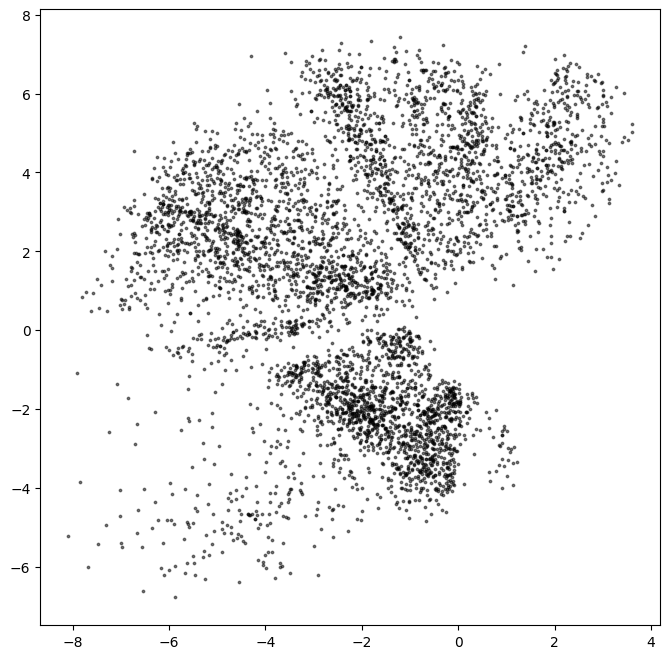

In [17]:
# Mostrar los puntos codificados en un espacio 2D
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

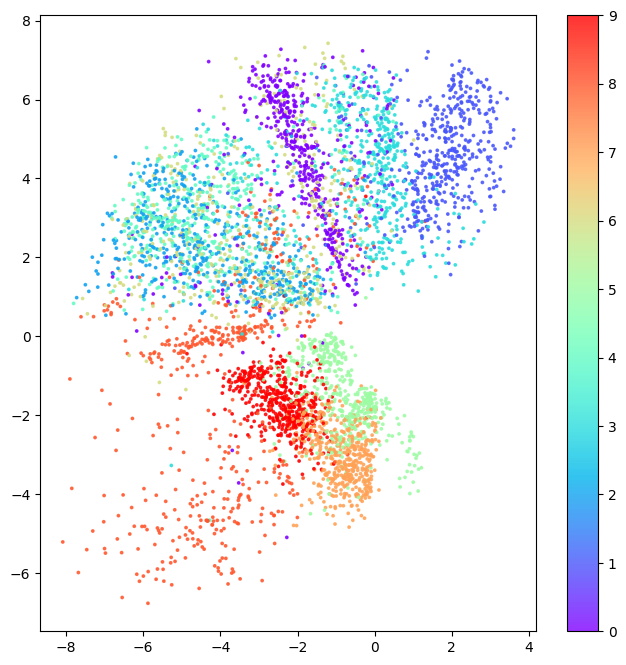

In [18]:
# Mostrar los puntos codificados en un espacio 2D, coloreados por la etiqueta de la prenda
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

### Generando utilizando el decodificador

In [19]:
# Obtener el rango de los embeddings existentes
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Ejemplo de cómo muestrear puntos en el espacio latente
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [20]:
# Decodificar los puntos muestreados
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


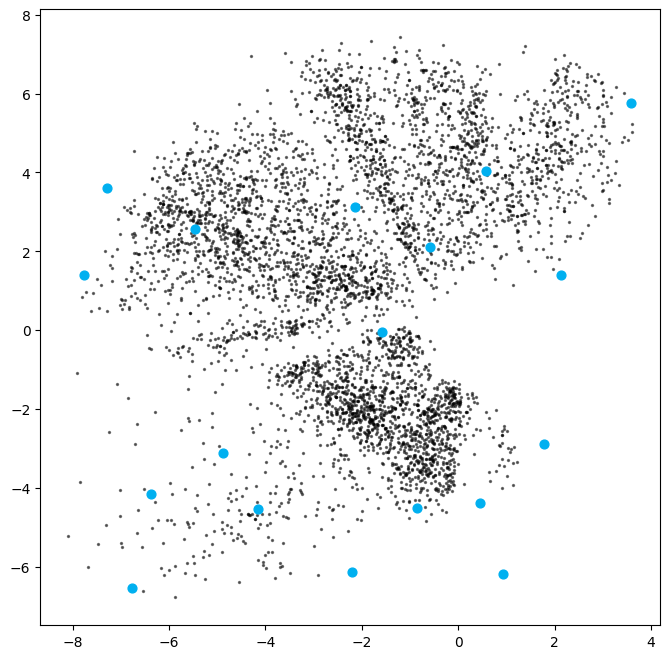

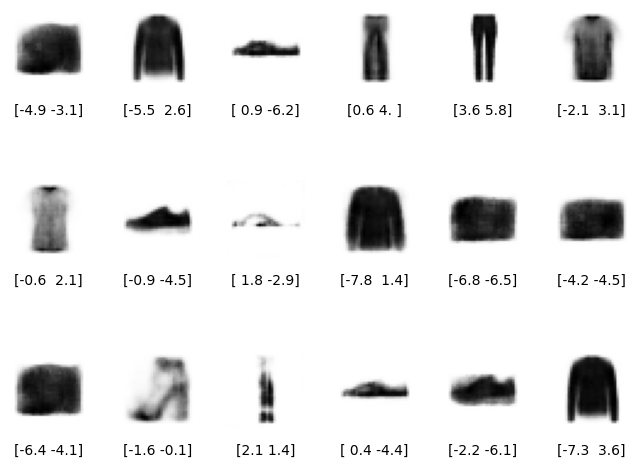

In [21]:

# Ploteamos ....
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... el espacio latente original ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)


# ... y los puntos generados en el espacio latente
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Añadir debajo una cuadrícula de las imágenes decodificadas
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


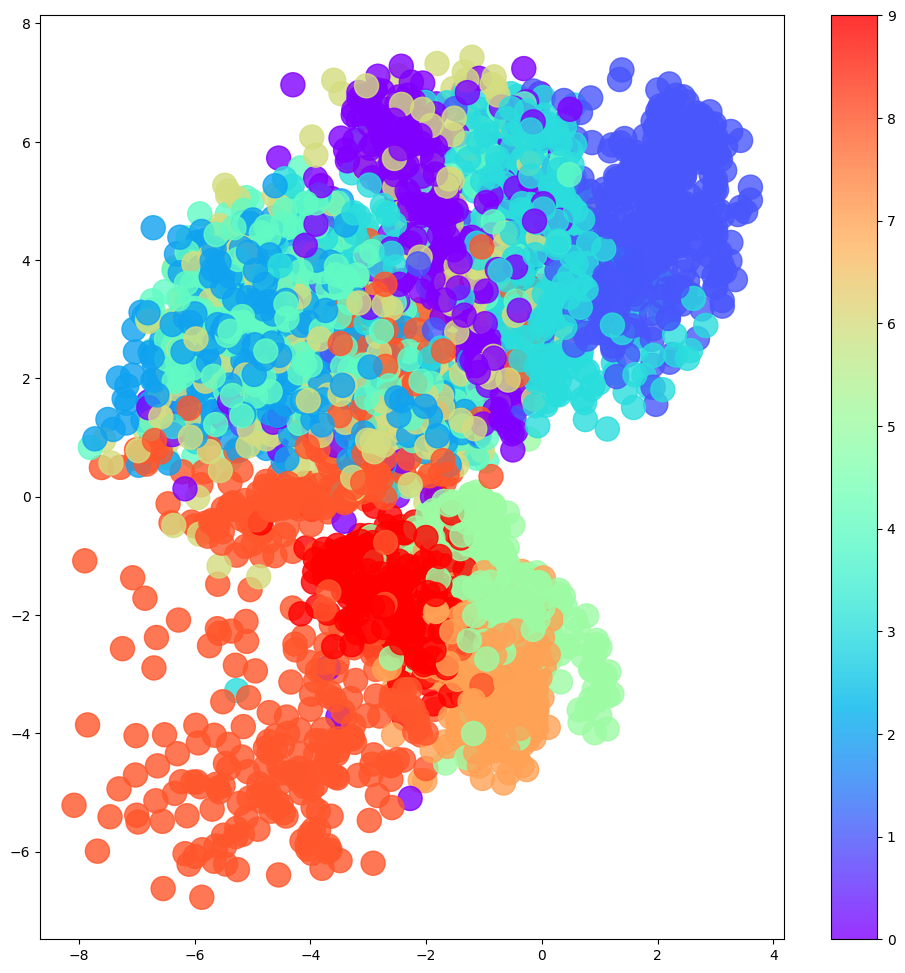

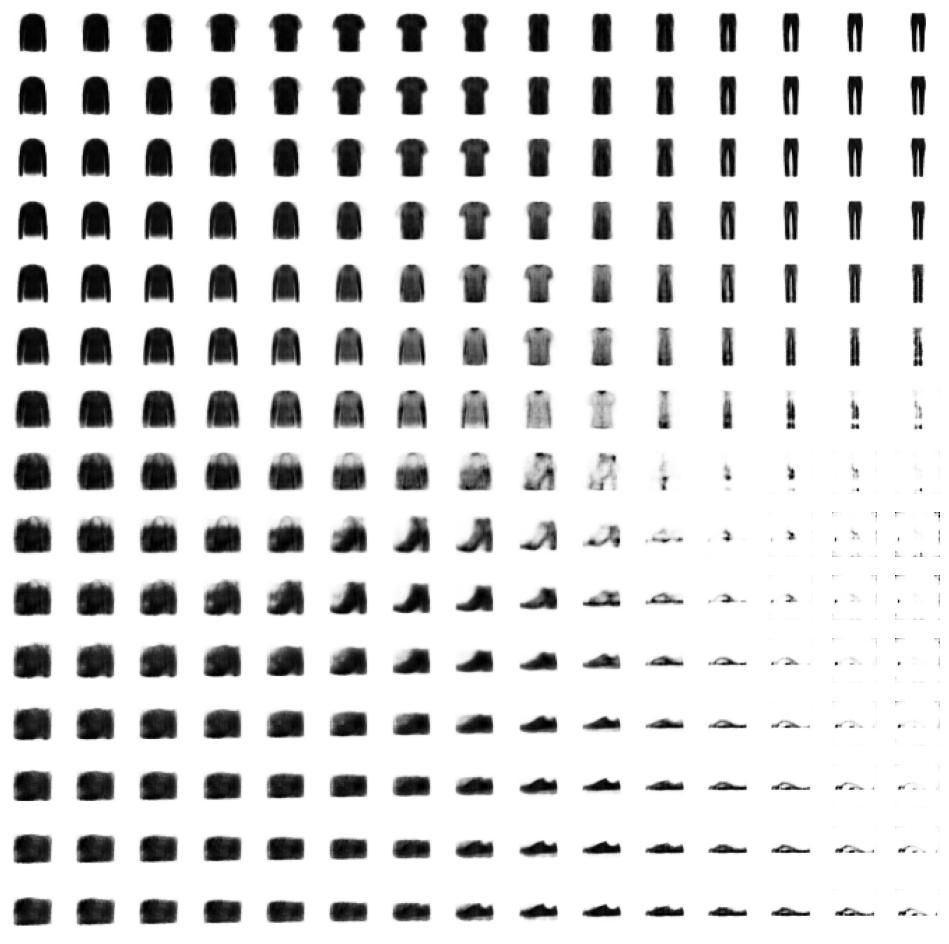

In [22]:

# Colorear los embeddings por su etiqueta (tipo de prenda - ver tabla)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")